In [ ]:
# Install package first
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/data

/content/drive/MyDrive/data


**Kindly Note:**

Don't be scared by how long this file looks, it's mostly just copy-pasting the model's fit, predict and evaluate functions.

### **READ ME: About Amazon Chronos and AutoGluon:**

**Chronos Github Page**: https://github.com/amazon-science/chronos-forecasting

**AutoGluon Website Page**: https://auto.gluon.ai/stable/tutorials/timeseries/index.html


---

- **AutoGluon-TimeSeries (AG-TS)** includes Chronos family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

  AG-TS provides a **robust and easy** way to use Chronos through the familiar TimeSeriesPredictor API. Roughly speaking, we can:

  1. Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training

  2. **Fine-tune** Chronos models on custom data to improve the accuracy
  
  3. **Handle covariates & static features** by combining Chronos with a tabular regression model

---
- **Amazon Chronos**: Chronos is a family of pretrained time series forecasting models based on language model architectures ( [T5 architecture](https://arxiv.org/abs/1910.10683)). The only difference is in the vocabulary size: Chronos-T5 models use 4096 different tokens, compared to 32128 of the original T5 models, resulting in fewer parameters.

  A time series is transformed into a sequence of tokens via **scaling and quantization**, and a language model is trained on these tokens using the **cross-entropy loss**, very similar to how people train a non-time-series LLM model. It uses **TSMixup and KernelSynth** to augment data quality. Once trained, **probabilistic forecasts** are obtained by **sampling multiple future trajectories** given the historical context.
  
  Chronos models have been trained on a large corpus of publicly available time series data (**84B for Chronos**, not sure the size for Chronos-Bolt, assume to be unchanged), as well as synthetic data generated using Gaussian processes.

For details on Chronos models, please refer to the [paper](https://arxiv.org/abs/2403.07815).


- Model, Parameters,  Based on

  chronos-bolt-tiny, 9M,  t5-efficient-tiny

  chronos-bolt-mini, 21M, t5-efficient-mini

  chronos-bolt-small,  48M, t5-efficient-small

  chronos-bolt-base, 205M,  t5-efficient-base

Parameters for other chronos models can be found on its Github page.

---

- **AutoGluon supports both the original Chronos models** (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), as well as the new, more accurate and up to 250x faster Chronos-Bolt⚡ models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)).

The easiest way to get started with Chronos is through the model-specific presets.

- **(recommended)** The new, fast Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Note that the **original Chronos models of size `small` and above require a GPU to run,** while **all Chronos-Bolt models can be run both on a CPU and a GPU.**

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).


# Weekly Data:

## Load data

In [ ]:
# individual account usage
weekly_usage = pd.read_csv("weekly_usage_individual.csv")
weekly_usage = weekly_usage.drop(columns=['Unnamed: 0'], errors='ignore')
weekly_usage['Datetime'] = pd.to_datetime(weekly_usage['Datetime'])
# overall usage
weekly_overall = pd.read_csv("weekly_usage_overall.csv")
weekly_overall = weekly_overall.drop(columns=['Unnamed: 0'], errors='ignore')
weekly_overall['Datetime'] = pd.to_datetime(weekly_overall['Datetime'])

In [ ]:
print(weekly_usage.describe())
print(weekly_usage.head())

                            Datetime         Usage
count                          77330  7.733000e+04
mean   2012-12-29 23:59:59.999999744  8.849055e+04
min              2011-01-02 00:00:00  0.000000e+00
25%              2012-01-01 00:00:00  4.158508e+03
50%              2012-12-30 00:00:00  1.771122e+04
75%              2013-12-29 00:00:00  4.667506e+04
max              2014-12-28 00:00:00  1.603728e+07
std                              NaN  4.775057e+05
    Datetime Account  Usage
0 2011-01-02  MT_001    0.0
1 2011-01-09  MT_001    0.0
2 2011-01-16  MT_001    0.0
3 2011-01-23  MT_001    0.0
4 2011-01-30  MT_001    0.0


In [ ]:
print(weekly_overall.describe())
print(weekly_overall.head())

                  Datetime         Usage
count                  209  2.090000e+02
mean   2012-12-30 00:00:00  3.274150e+07
min    2011-01-02 00:00:00  4.498581e+06
25%    2012-01-01 00:00:00  2.379862e+07
50%    2012-12-30 00:00:00  3.271107e+07
75%    2013-12-29 00:00:00  3.865330e+07
max    2014-12-28 00:00:00  4.973289e+07
std                    NaN  8.930854e+06
    Datetime         Usage
0 2011-01-02  4.498581e+06
1 2011-01-09  1.996876e+07
2 2011-01-16  1.966853e+07
3 2011-01-23  1.925900e+07
4 2011-01-30  1.916211e+07


## Weekly Usage Overall

In [ ]:
weekly_overall['item_id'] = 1
weekly_overall = weekly_overall.rename(columns={'Datetime': 'timestamp', 'Usage': 'target'})
print(weekly_overall.head())

   timestamp        target  item_id
0 2011-01-02  4.498581e+06        1
1 2011-01-09  1.996876e+07        1
2 2011-01-16  1.966853e+07        1
3 2011-01-23  1.925900e+07        1
4 2011-01-30  1.916211e+07        1


In [ ]:
week_overall_data = TimeSeriesDataFrame.from_data_frame(weekly_overall)
print(week_overall_data.head())
week_overall_data.describe()

                          target
item_id timestamp               
1       2011-01-02  4.498581e+06
        2011-01-09  1.996876e+07
        2011-01-16  1.966853e+07
        2011-01-23  1.925900e+07
        2011-01-30  1.916211e+07


,target
count,2.090000e+02
mean,3.274150e+07
std,8.930854e+06
min,4.498581e+06
25%,2.379862e+07
50%,3.271107e+07
75%,3.865330e+07
max,4.973289e+07


### If we use Chronos bolt_small model:

In [ ]:
prediction_length = int(len(week_overall_data)*0.2)
train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_194659'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.48 GB / 12.67 GB (90.5%)
Disk Space Avail:   67.77 GB / 107.72 GB (62.9%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-SUN'
Provided

In [ ]:
print(train_data.describe())
print(train_data.head())
print(test_data.describe())
print(test_data.head())

             target
count  1.680000e+02
mean   3.118447e+07
std    8.958026e+06
min    4.498581e+06
25%    2.209990e+07
50%    3.153991e+07
75%    3.672512e+07
max    4.973289e+07
                          target
item_id timestamp               
1       2011-01-02  4.498581e+06
        2011-01-09  1.996876e+07
        2011-01-16  1.966853e+07
        2011-01-23  1.925900e+07
        2011-01-30  1.916211e+07
             target
count  2.090000e+02
mean   3.274150e+07
std    8.930854e+06
min    4.498581e+06
25%    2.379862e+07
50%    3.271107e+07
75%    3.865330e+07
max    4.973289e+07
                          target
item_id timestamp               
1       2011-01-02  4.498581e+06
        2011-01-09  1.996876e+07
        2011-01-16  1.966853e+07
        2011-01-23  1.925900e+07
        2011-01-30  1.916211e+07


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


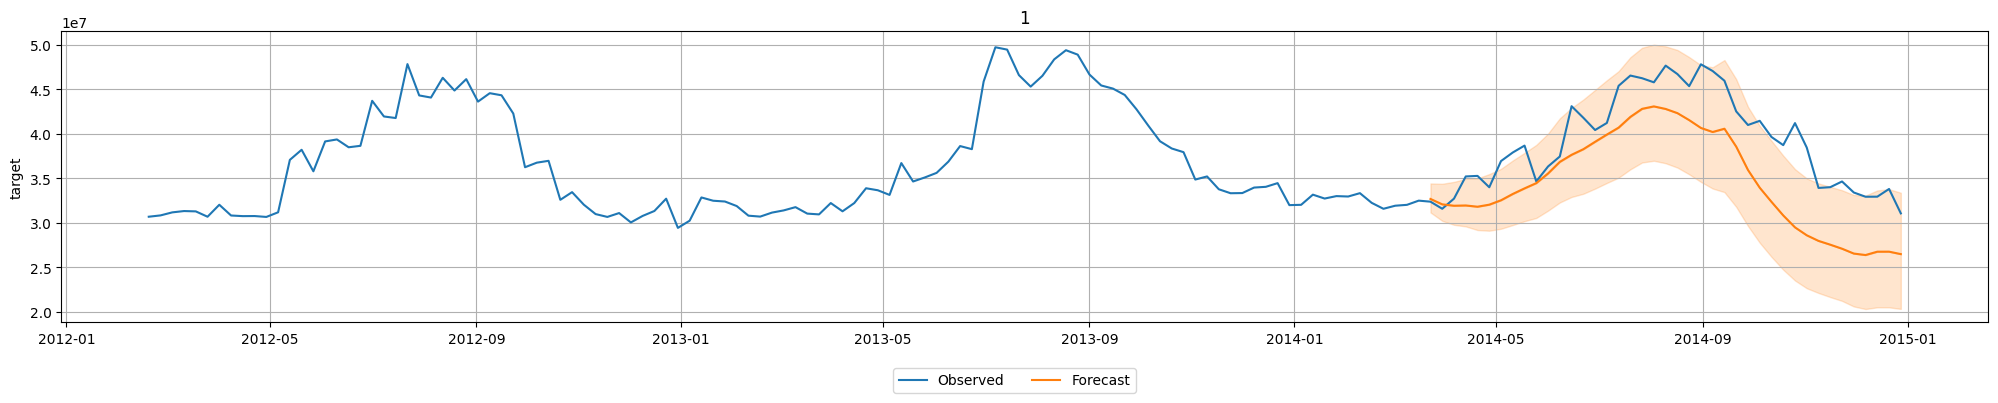

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=150,
);

In [ ]:
print(predictions.shape)
predictions.head()

(41, 10)


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2014-03-23  32681116.0  31166438.0  31746078.0  32096810.0   
        2014-03-30  32074930.0  30223558.0  30913782.0  31354548.0   
        2014-04-06  31918268.0  29774744.0  30576344.0  31094998.0   
        2014-04-13  31948990.0  29596096.0  30458298.0  30990616.0   
        2014-04-20  31808718.0  29186492.0  30141846.0  30781378.0   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2014-03-23  32385666.0  32681116.0  32994550.0  33362704.0   
        2014-03-30  31726910.0  32074930.0  32466672.0  32955924.0   
        2014-04-06  31505450.0  31918268.0  32384684.0  32921916.0   
        2014-04-13  31470618.0  31948990.0  32453596.0  33061938.0   
        2014-04-20  31295630.0  31808718.0  32388686.0  33040300.0   

                           0.8         0.9  
item_id timestamp                           
1       2014-03-23  33802292.0  34423620.0  
        2014-03-30  33531348.0  34384780.0  
        2014-04-06  33593820.0  34600848.0  
        2014-04-13  33826352.0  34940520.0  
        2014-04-20  33811204.0  34993652.0

In [ ]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


{'WQL': -0.08516733249919754}

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.085167,None,1.936776,None,14.645858,1,-0.085167,-4.630450e+06,-2.847313e+13,-5.336022e+06,-0.118819


Overall MAPE for Test Period 1: 6.57%
Overall MAPE for Test Period 2: 9.36%
Overall MAPE for Test Period 3: 20.32%


<Figure size 640x480 with 0 Axes>

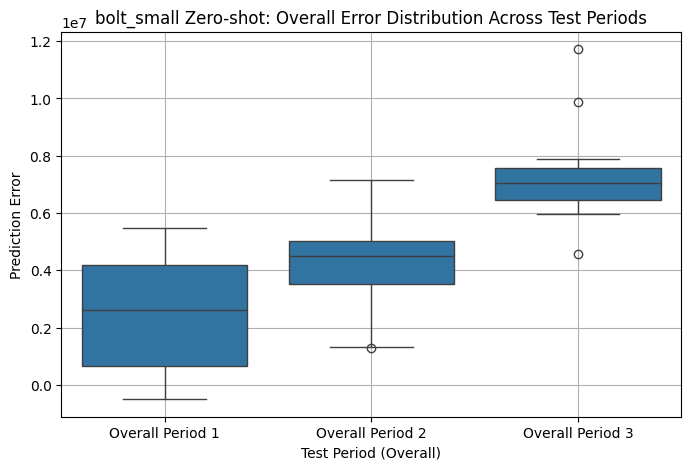

In [ ]:
test_data_pd = test_data.reset_index().set_index('timestamp')['target']
# split test set into 3 equal regions

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def three_split_plot(predictions, subtitle = ""):

    test_predict = predictions.reset_index().set_index('timestamp')['mean']
    test_split = np.array_split(test_predict.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = mape(test_data_pd.loc[period], test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = test_data_pd.loc[period] - test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    if subtitle: plt.suptitle(subtitle, fontsize=12)

    plt.figure(figsize=(8,5))
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()

three_split_plot(predictions, 'bolt_small Zero-shot')

### If we use Chronos bolt_base model:

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_194723'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.68 GB / 12.67 GB (84.3%)
Disk Space Avail:   67.77 GB / 107.72 GB (62.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-SUN'
Provided t

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


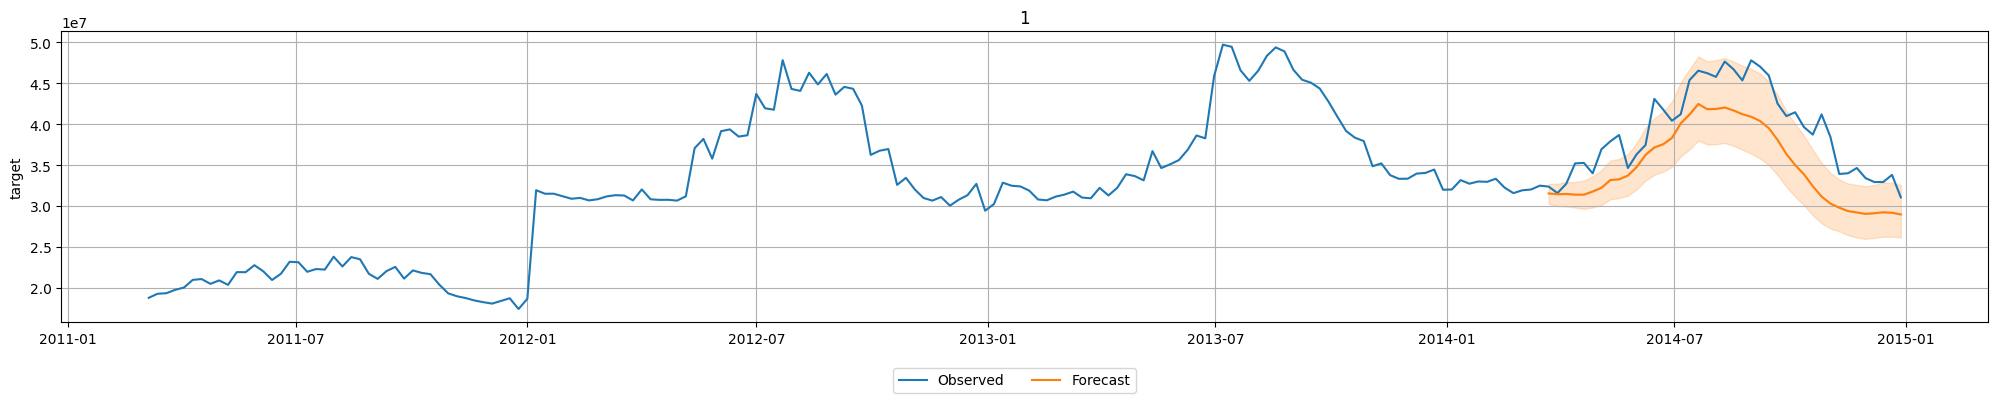

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=200,
);

In [ ]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


{'WQL': -0.08312478753091437}

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.083125,None,3.786678,None,0.006629,1,-0.083125,-4.242827e+06,-2.231087e+13,-4.723438e+06,-0.106833


Overall MAPE for Test Period 1: 7.74%
Overall MAPE for Test Period 2: 9.99%
Overall MAPE for Test Period 3: 14.59%


<Figure size 640x480 with 0 Axes>

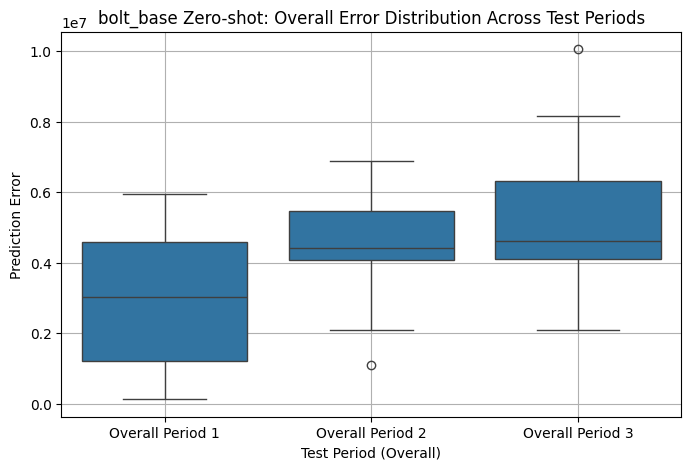

In [ ]:
three_split_plot(predictions, "bolt_base Zero-shot")

## Fine tune weekly usage overall model

### fine tune bolt_small

In [ ]:
# prediction_length = int(len(week_overall_data)*0.2)
# train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=120,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_194728'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.68 GB / 12.67 GB (84.2%)
Disk Space Avail:   67.77 GB / 107.72 GB (62.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 '

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small],-0.053611,-0.085317,1.112117,0.063359,98.952891,2,-0.053611,-2.292272e+06,-7.352864e+12,-2.711617e+06,-0.059662
1,ChronosZeroShot[bolt_small],-0.085167,-0.114223,1.716368,1.548526,0.017469,1,-0.085167,-4.630450e+06,-2.847313e+13,-5.336022e+06,-0.118819


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


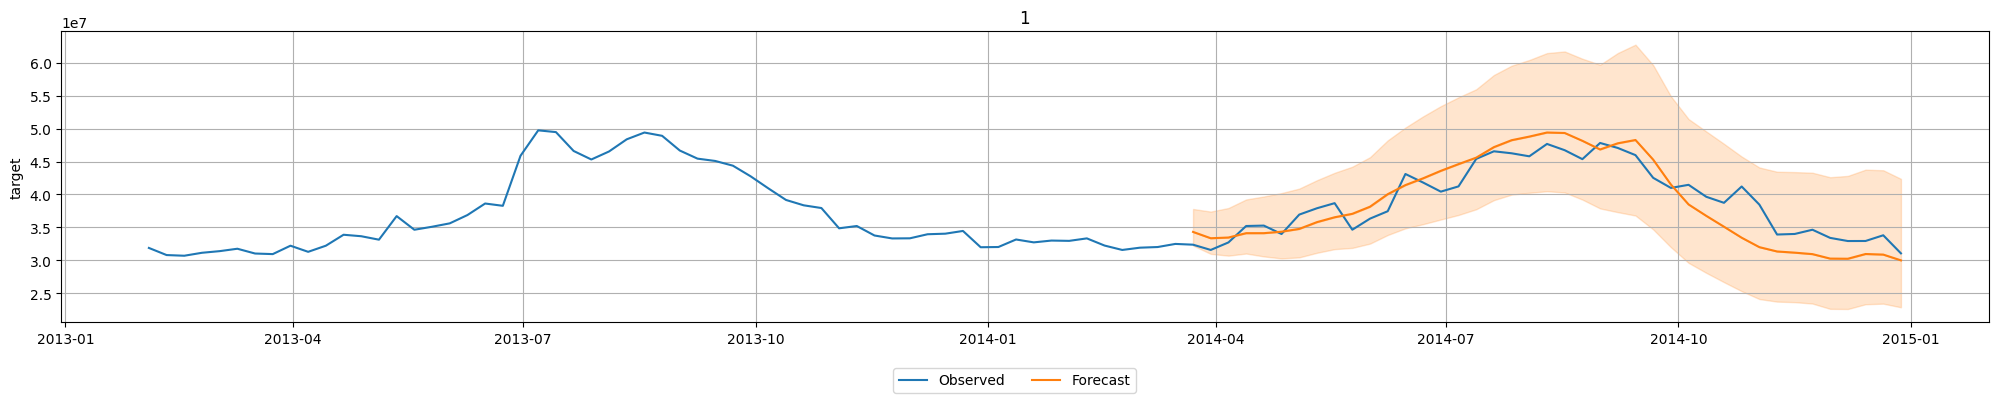

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);

Overall MAPE for Test Period 1: 4.47%
Overall MAPE for Test Period 2: 4.31%
Overall MAPE for Test Period 3: 9.37%


<Figure size 640x480 with 0 Axes>

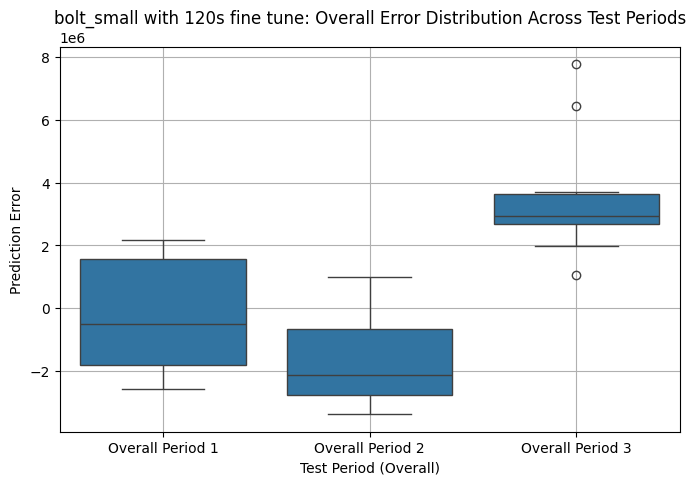

In [ ]:
three_split_plot(predictions, 'bolt_small with 120s fine tune')

**Manually defined hyperparameters**

In [ ]:
from autogluon.common import space

prediction_length = int(len(week_overall_data)*0.2)
train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=600,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_194913'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.18 GB / 12.67 GB (80.3%)
Disk Space Avail:   67.60 GB / 107.72 GB (62.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                          

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,ChronosFineTuned[bolt_small]/T1,-0.055450,-0.083969,0.949212,0.082501,149.599035,2,-0.055450,-2.578216e+06,-9.023369e+12,-3.003892e+06,-0.066755,-2.163626
1,WeightedEnsemble,-0.082887,-0.049449,3.355237,1.612819,0.378889,4,-0.082887,-4.455228e+06,-2.645858e+13,-5.143790e+06,-0.111445,-3.738805
2,ChronosZeroShot[bolt_small],-0.085167,-0.114223,1.513607,1.467958,0.015387,1,-0.085167,-4.630450e+06,-2.847313e+13,-5.336022e+06,-0.118819,-3.885850
3,ChronosFineTuned[bolt_small]/T2,-0.104903,-0.053069,0.886639,0.062360,122.852764,3,-0.104903,-5.410252e+06,-4.153225e+13,-6.444552e+06,-0.132782,-4.540256


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


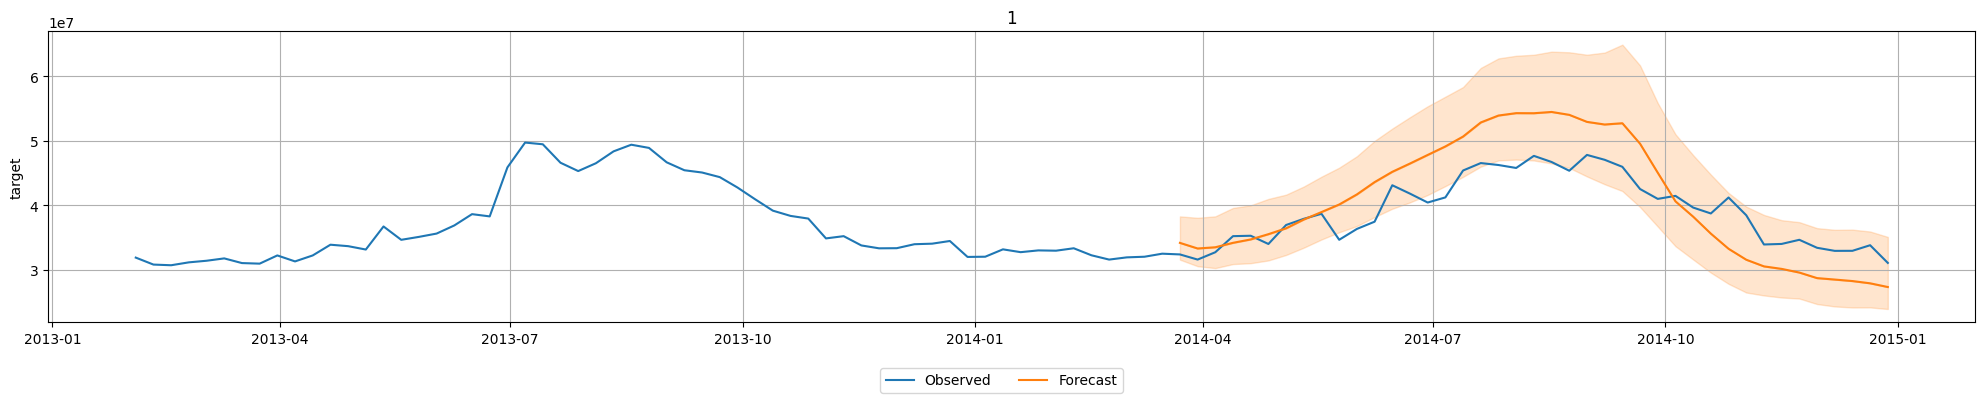

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);

Overall MAPE for Test Period 1: 6.26%
Overall MAPE for Test Period 2: 15.06%
Overall MAPE for Test Period 3: 12.18%


<Figure size 640x480 with 0 Axes>

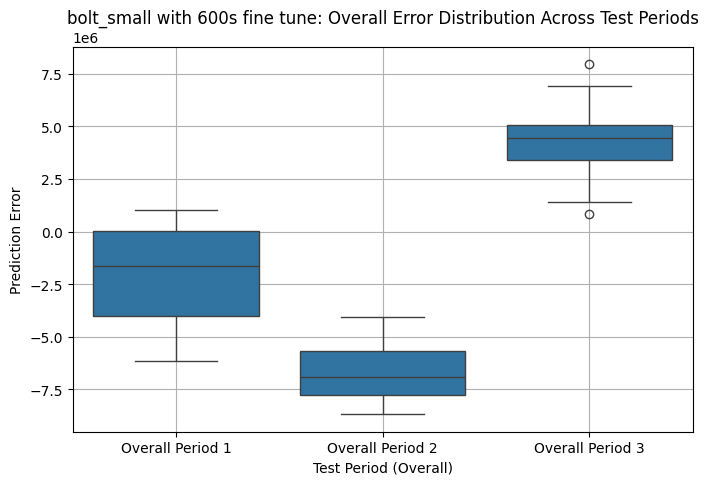

In [ ]:
three_split_plot(predictions, 'bolt_small with 600s fine tune')

In [ ]:
from autogluon.common import space

prediction_length = int(len(week_overall_data)*0.2)
train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_195352'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.07 GB / 12.67 GB (79.4%)
Disk Space Avail:   67.26 GB / 107.72 GB (62.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                          

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,ChronosFineTuned[bolt_small]/T1,-0.055450,-0.083969,0.944220,0.113822,138.755116,2,-0.055450,-2.578216e+06,-9.023369e+12,-3.003892e+06,-0.066755,-2.163626
1,ChronosZeroShot[bolt_small],-0.085167,-0.114223,1.541453,1.667197,0.015469,1,-0.085167,-4.630450e+06,-2.847313e+13,-5.336022e+06,-0.118819,-3.885850
2,WeightedEnsemble,-0.089916,-0.042793,2.622306,1.730073,0.528622,5,-0.089916,-4.850216e+06,-3.109099e+13,-5.575929e+06,-0.121137,-4.070277
3,ChronosFineTuned[bolt_small]/T2,-0.104124,-0.053845,1.039551,0.130093,148.039170,3,-0.104124,-5.379109e+06,-4.067615e+13,-6.377786e+06,-0.132330,-4.514121
4,ChronosFineTuned[bolt_small]/T3,-0.115212,-0.049854,1.074625,0.062876,132.704282,4,-0.115212,-5.973534e+06,-4.988654e+13,-7.063040e+06,-0.146726,-5.012959


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Overall MAPE for Test Period 1: 7.46%
Overall MAPE for Test Period 2: 16.35%
Overall MAPE for Test Period 3: 12.57%


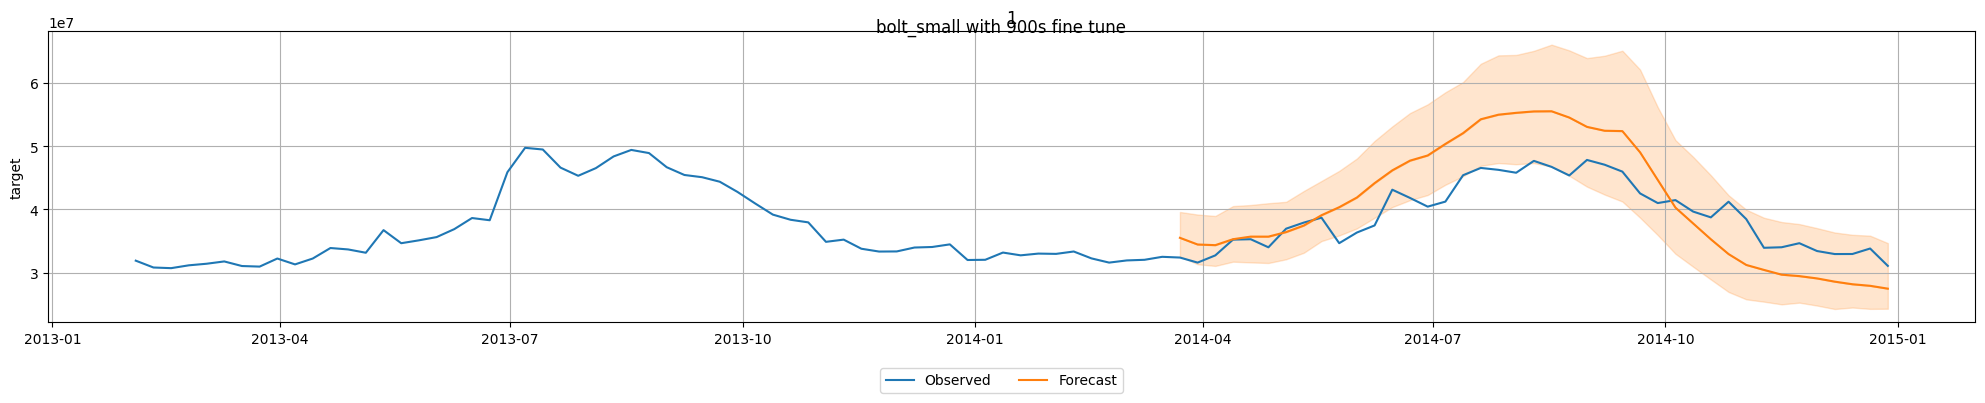

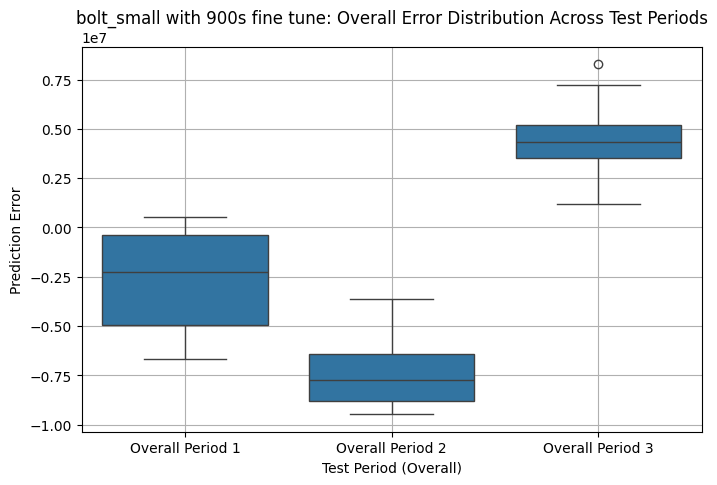

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);
three_split_plot(predictions, 'bolt_small with 900s fine tune')

**Performance is unchanged, there may be overfitting or it's just bolt_small cannot handle such case. Try fine-tune bolt_base.**

### fine tune bolt_base

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=120,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_200100'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.03 GB / 12.67 GB (79.1%)
Disk Space Avail:   66.75 GB / 107.72 GB (62.0%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_base'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'qu

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_base],-0.065991,-0.083331,2.475326,0.246982,109.902240,2,-0.065991,-3.488302e+06,-1.642860e+13,-4.053221e+06,-0.087580
1,ChronosZeroShot[bolt_base],-0.083125,-0.096270,1.802900,2.003847,0.019032,1,-0.083125,-4.242827e+06,-2.231087e+13,-4.723438e+06,-0.106833


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_base]


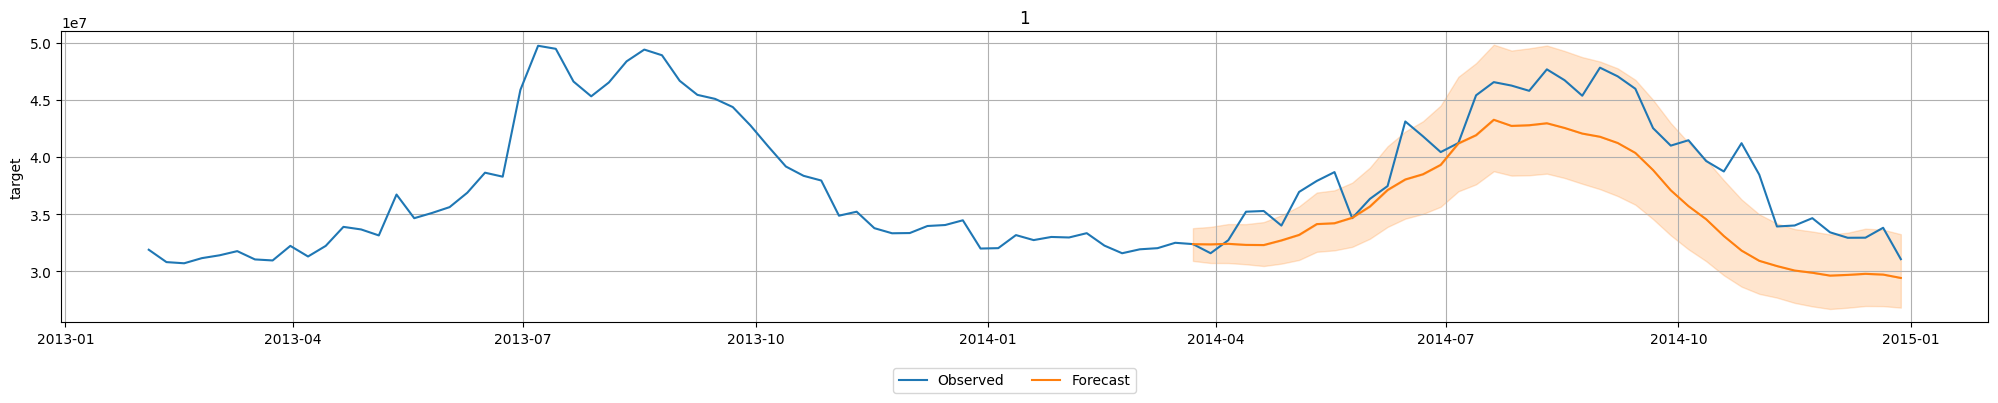

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);

Overall MAPE for Test Period 1: 5.59%
Overall MAPE for Test Period 2: 8.10%
Overall MAPE for Test Period 3: 12.89%


<Figure size 640x480 with 0 Axes>

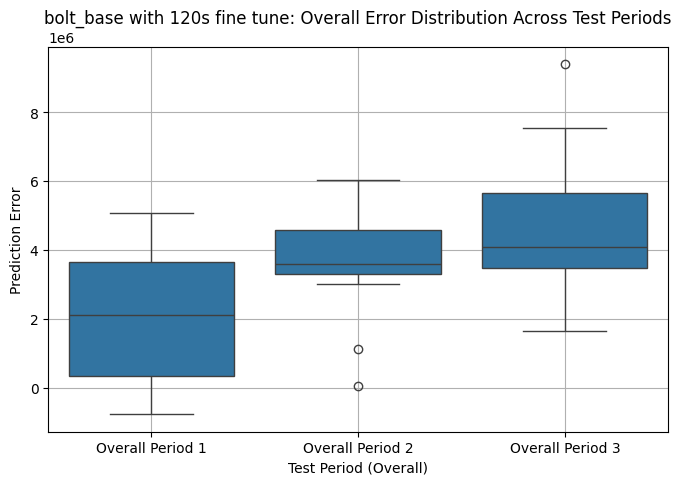

In [ ]:
three_split_plot(predictions, 'bolt_base with 120s fine tune')

**Manually defined hyperparameters:**

In [ ]:
from autogluon.common import space

prediction_length = int(len(week_overall_data)*0.2)
train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=600,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_200258'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.47 GB / 12.67 GB (74.7%)
Disk Space Avail:   66.02 GB / 107.72 GB (61.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                            

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,WeightedEnsemble,-0.045370,-0.066362,2.023939,0.255364,0.357117,3,-0.045370,-2.269731e+06,-8.050230e+12,-2.837293e+06,-0.059613,-1.904747
1,ChronosFineTuned[bolt_base]/T1,-0.045370,-0.066362,2.019552,0.255364,250.342223,2,-0.045370,-2.269731e+06,-8.050230e+12,-2.837293e+06,-0.059613,-1.904747
2,ChronosZeroShot[bolt_base],-0.083125,-0.096270,1.912375,1.770538,0.013318,1,-0.083125,-4.242827e+06,-2.231087e+13,-4.723438e+06,-0.106833,-3.560559


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_base]/T1


Overall MAPE for Test Period 1: 4.59%
Overall MAPE for Test Period 2: 3.08%
Overall MAPE for Test Period 3: 10.54%


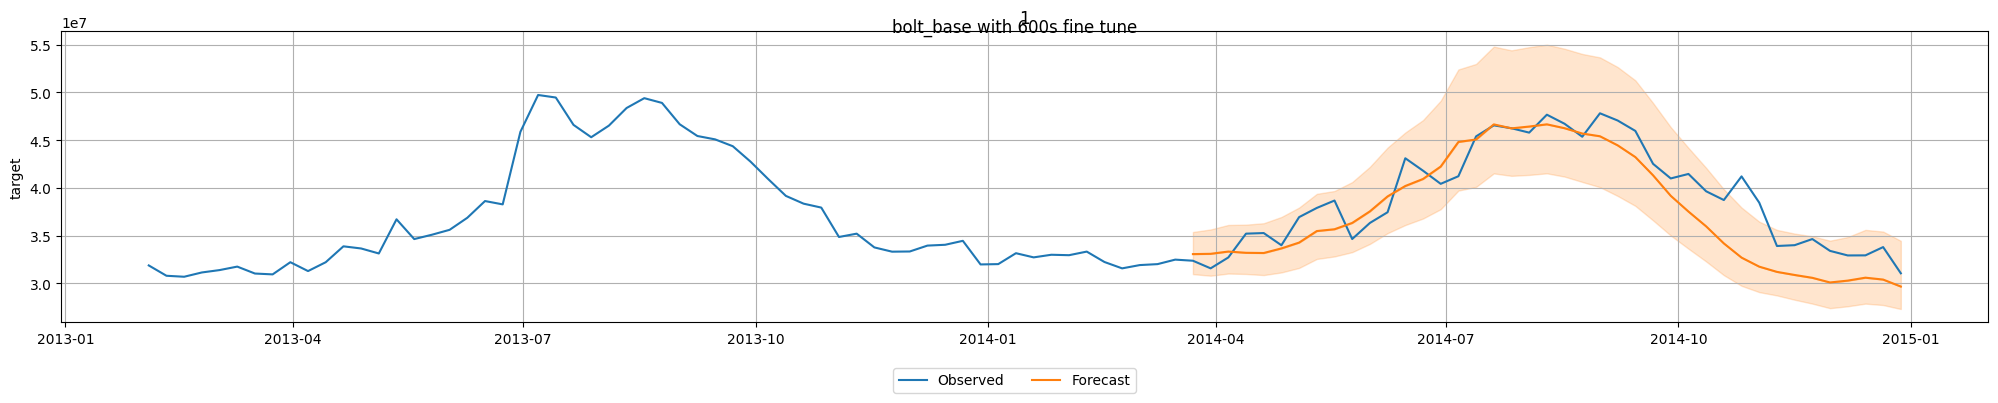

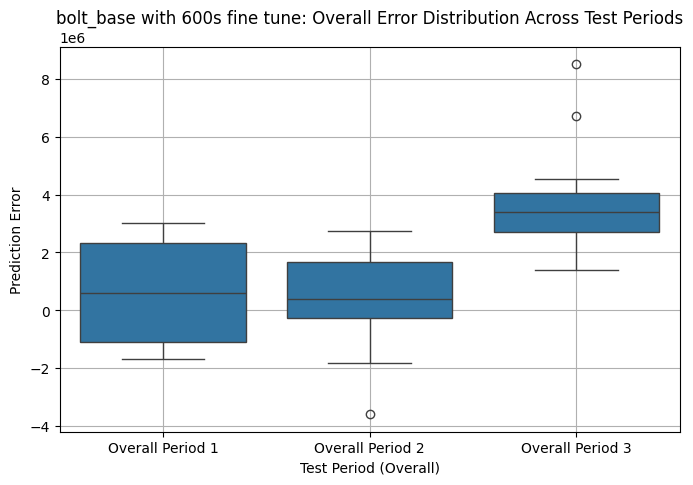

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);
three_split_plot(predictions, 'bolt_base with 600s fine tune')

In [ ]:
from autogluon.common import space

prediction_length = int(len(week_overall_data)*0.2)
train_data, test_data = week_overall_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,250,500,1000),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=700,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 700s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_200716'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.49 GB / 12.67 GB (74.9%)
Disk Space Avail:   65.30 GB / 107.72 GB (60.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                            

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,WeightedEnsemble,-0.044651,-0.063246,2.066399,0.192641,0.249080,3,-0.044651,-2.235663e+06,-7.660431e+12,-2.767748e+06,-0.058854,-1.876157
1,ChronosFineTuned[bolt_base]/T1,-0.044651,-0.063246,2.043216,0.192641,293.375416,2,-0.044651,-2.235663e+06,-7.660431e+12,-2.767748e+06,-0.058854,-1.876157
2,ChronosZeroShot[bolt_base],-0.083125,-0.096270,1.883310,1.733553,0.012742,1,-0.083125,-4.242827e+06,-2.231087e+13,-4.723438e+06,-0.106833,-3.560559


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_base]/T1


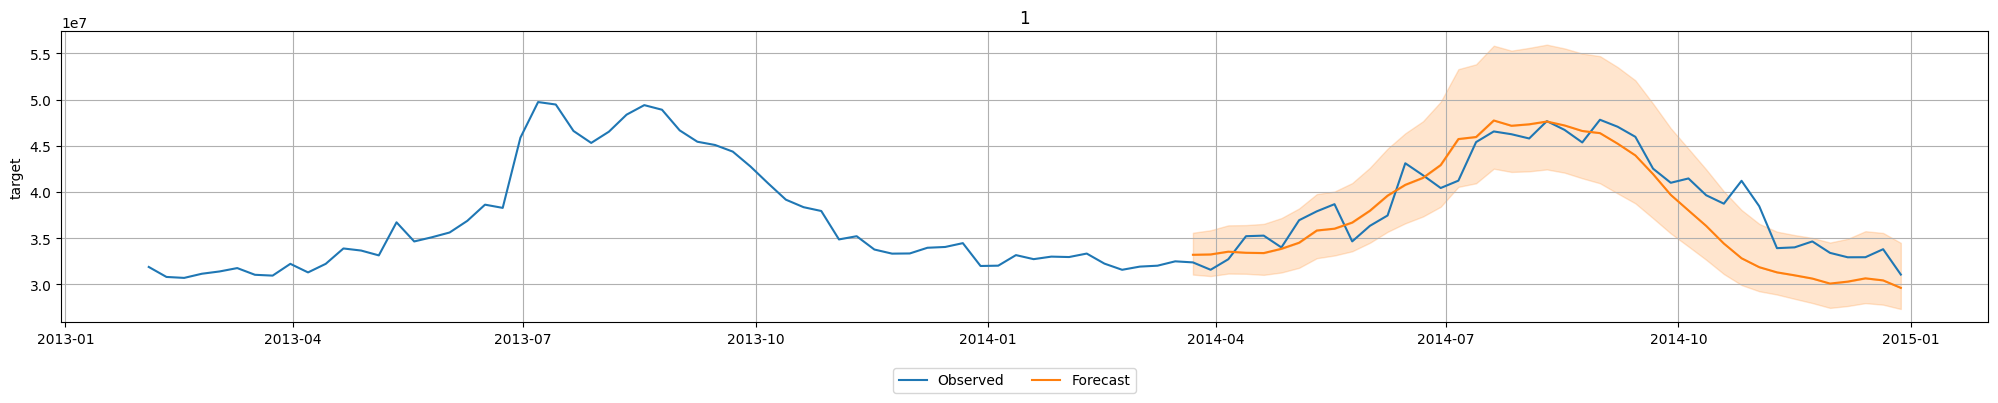

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=week_overall_data,
    predictions=predictions,
    item_ids=week_overall_data.item_ids[:],
    max_history_length=100,
);

Overall MAPE for Test Period 1: 4.45%
Overall MAPE for Test Period 2: 3.28%
Overall MAPE for Test Period 3: 10.24%


<Figure size 640x480 with 0 Axes>

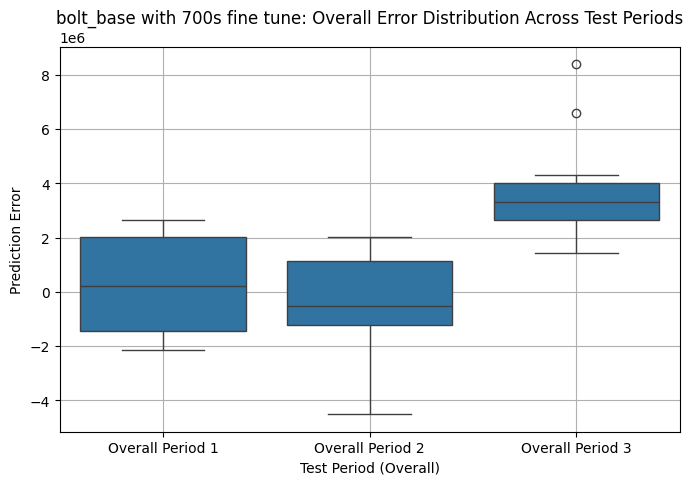

In [ ]:
three_split_plot(predictions, 'bolt_base with 700s fine tune')

**Fine-tuned bolt_base result leads to better performance -- MAPE of 6.17%.**

## Weekly Usage Individual

**Note:** Since some clients were created after 2011, **in these cases consumption were considered zero**.

 For these time series with lots of 0, there are fewer history points for the model to learn, thus may **interfere with the performance** (the final result seems to be not that promising), especially for the case here because we predict for each individual time series respectively rather than their overall sum as in above.

**Thus, for later group, you can try delete these missing points and then see if performance will improve.**

In [ ]:
weekly_usage = weekly_usage.rename(columns={'Datetime': 'timestamp', 'Account': 'item_id', 'Usage': 'target'})
print(weekly_usage.head())

   timestamp item_id  target
0 2011-01-02  MT_001     0.0
1 2011-01-09  MT_001     0.0
2 2011-01-16  MT_001     0.0
3 2011-01-23  MT_001     0.0
4 2011-01-30  MT_001     0.0


In [ ]:
weekly_usage_data = TimeSeriesDataFrame.from_data_frame(weekly_usage)
print(weekly_usage_data.head())
weekly_usage_data.describe()

                    target
item_id timestamp         
MT_001  2011-01-02     0.0
        2011-01-09     0.0
        2011-01-16     0.0
        2011-01-23     0.0
        2011-01-30     0.0


,target
count,7.733000e+04
mean,8.849055e+04
std,4.775057e+05
min,0.000000e+00
25%,4.158508e+03
50%,1.771122e+04
75%,4.667506e+04
max,1.603728e+07


#### if we try bolt_small model:

In [ ]:
prediction_length = int(len(weekly_usage_data)*0.2/370)
train_data, test_data = weekly_usage_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_201216'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.47 GB / 12.67 GB (74.8%)
Disk Space Avail:   64.57 GB / 107.72 GB (59.9%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-SUN'
Provided 

In [ ]:
print(train_data.describe())
print(train_data.head())
print(test_data.describe())
print(test_data.head())

             target
count  6.216000e+04
mean   8.428234e+04
std    4.574284e+05
min    0.000000e+00
25%    1.120719e+03
50%    1.660097e+04
75%    4.567265e+04
max    1.603728e+07
                    target
item_id timestamp         
MT_001  2011-01-02     0.0
        2011-01-09     0.0
        2011-01-16     0.0
        2011-01-23     0.0
        2011-01-30     0.0
             target
count  7.733000e+04
mean   8.849055e+04
std    4.775057e+05
min    0.000000e+00
25%    4.158508e+03
50%    1.771122e+04
75%    4.667506e+04
max    1.603728e+07
                    target
item_id timestamp         
MT_001  2011-01-02     0.0
        2011-01-09     0.0
        2011-01-16     0.0
        2011-01-23     0.0
        2011-01-30     0.0


Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


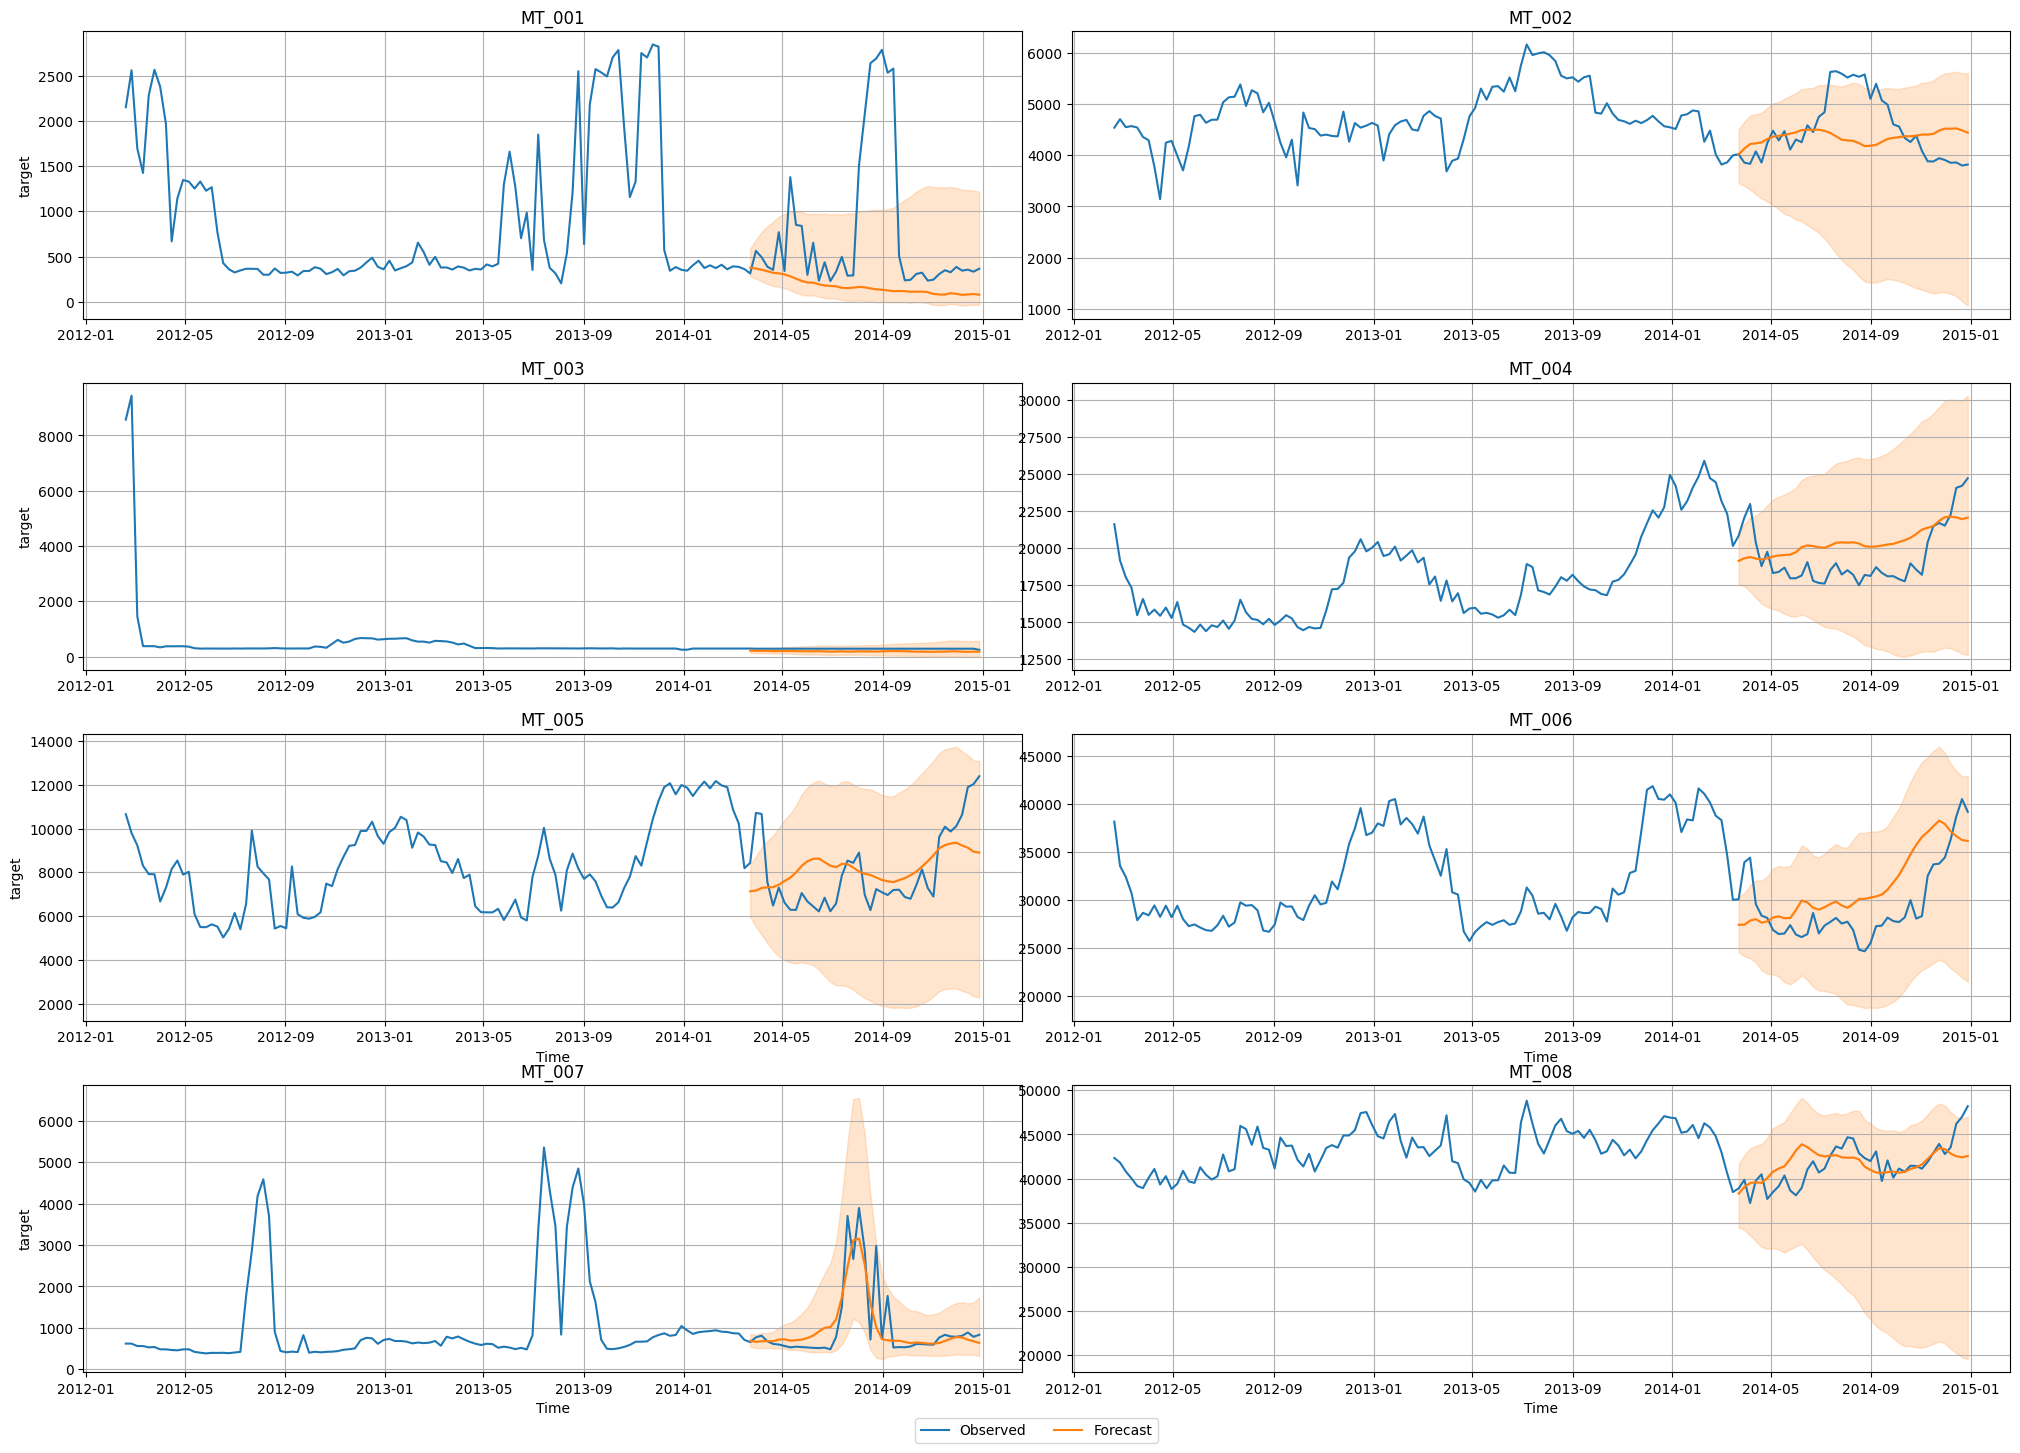

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=weekly_usage_data,
    predictions=predictions,
    item_ids=weekly_usage_data.item_ids[:8],
    max_history_length=150,
);

In [ ]:
print(predictions.shape)
predictions.head()

(15170, 10)


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
MT_001  2014-03-23  375.553955  280.708160  325.680267  349.990448   
        2014-03-30  368.269928  256.036865  303.707764  333.358185   
        2014-04-06  354.154999  225.934265  277.600616  309.123627   
        2014-04-13  338.201385  197.211609  249.374512  284.122925   
        2014-04-20  319.730896  172.996826  224.947083  261.462067   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
MT_001  2014-03-23  366.001099  375.553955  381.896149  392.542542   
        2014-03-30  354.022064  368.269928  378.912292  395.904724   
        2014-04-06  333.199493  354.154999  373.371552  400.214294   
        2014-04-13  313.365753  338.201385  363.667755  404.469055   
        2014-04-20  291.857239  319.730896  348.141754  394.754883   

                           0.8         0.9  
item_id timestamp                           
MT_001  2014-03-23  427.277405  588.097290  
        2014-03-30  451.336731  685.239746  
        2014-04-06  480.010223  770.761536  
        2014-04-13  508.898315  835.953125  
        2014-04-20  516.907959  885.670593

In [ ]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


{'WQL': -0.1044469873097661}

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_small],-0.104447,None,6.578749,None,0.006288,1,-0.104447,-14409.604976,-1.985597e+10,-140911.207536,-0.213396


#### if we try bolt_base model:

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_201226'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.47 GB / 12.67 GB (74.7%)
Disk Space Avail:   64.57 GB / 107.72 GB (59.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'W-SUN'
Provided tr

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


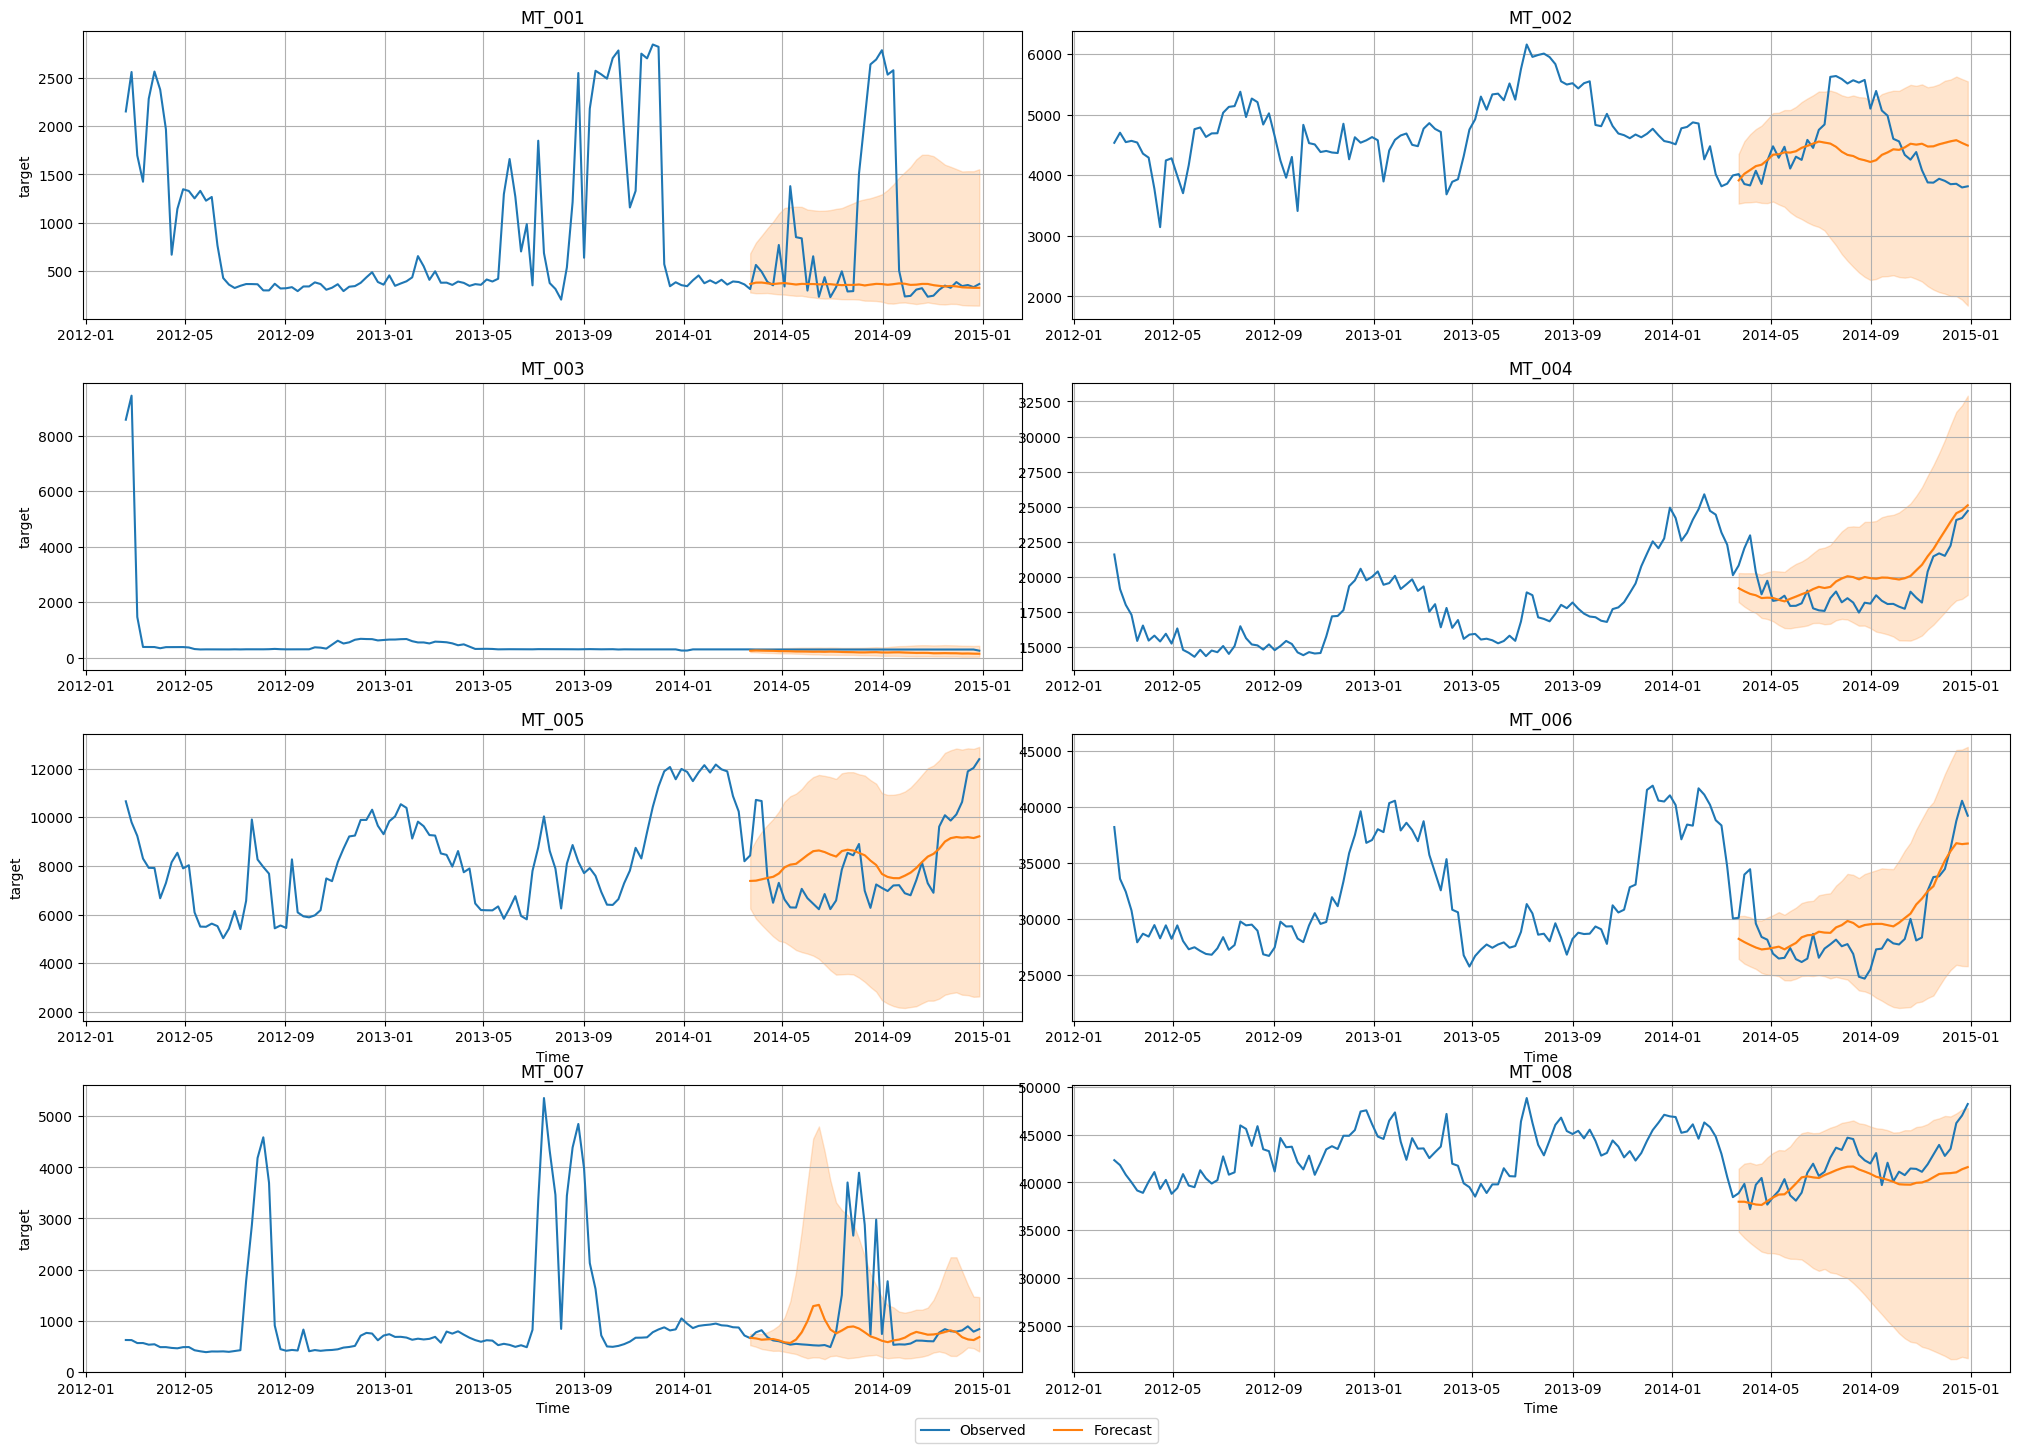

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=weekly_usage_data,
    predictions=predictions,
    item_ids=weekly_usage_data.item_ids[:8],
    max_history_length=150,
);

In [ ]:
print(predictions.shape)
predictions.head()

(15170, 10)


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
MT_001  2014-03-23  365.510620  277.562347  317.366089  342.368774   
        2014-03-30  379.884949  269.590302  319.718994  349.754578   
        2014-04-06  381.014099  270.159241  322.923187  352.731628   
        2014-04-13  372.765106  271.978668  321.748413  348.751648   
        2014-04-20  364.811707  264.104858  314.164337  340.083221   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
MT_001  2014-03-23  358.265350  365.510620  370.288055  379.934875   
        2014-03-30  369.047180  379.884949  386.436951  400.452362   
        2014-04-06  370.938416  381.014099  388.682922  404.451508   
        2014-04-13  363.401123  372.765106  381.562531  404.764801   
        2014-04-20  354.835266  364.811707  377.823181  409.766663   

                           0.8          0.9  
item_id timestamp                            
MT_001  2014-03-23  415.742798   682.279358  
        2014-03-30  451.449371   793.531494  
        2014-04-06  470.853912   866.353943  
        2014-04-13  486.637878   941.502197  
        2014-04-20  509.036530  1010.592102

In [ ]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


{'WQL': -0.09826920396719524}

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL','MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,Chronos[bolt_base],-0.098269,None,19.210797,None,0.006396,1,-0.098269,-13830.671204,-1.973565e+10,-140483.620041,-0.202923


## Fine tune weekly usage individual model

### fine tune bolt_small:

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_201249'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.46 GB / 12.67 GB (74.7%)
Disk Space Avail:   64.57 GB / 107.72 GB (59.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'qu

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_small],-0.092831,-0.145529,4.809942,4.689609,47.089096,2,-0.092831,-12477.325010,-1.635944e+10,-127904.013509,-0.209556
1,ChronosZeroShot[bolt_small],-0.104447,-0.158281,5.553895,4.702387,0.054094,1,-0.104447,-14409.604976,-1.985597e+10,-140911.207536,-0.213396


**manually set hyperparameter space for fine tune:**

In [ ]:
from autogluon.common import space

prediction_length = int(len(weekly_usage_data)*0.2/370)
train_data, test_data = weekly_usage_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,500,1000,1250),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_201357'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.48 GB / 12.67 GB (74.8%)
Disk Space Avail:   64.39 GB / 107.72 GB (59.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                           

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE', 'MASE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE,MASE
0,WeightedEnsemble,-0.083507,-0.111830,11.002498,6.436196,2.907851,5,-0.083507,-11385.667300,-1.363024e+10,-116748.610753,-0.214982,-5.491471
1,ChronosFineTuned[bolt_small]/T2,-0.083579,-0.113141,4.739793,3.028173,152.422285,3,-0.083579,-11389.015740,-1.330483e+10,-115346.548501,-0.219623,-5.464501
2,ChronosFineTuned[bolt_small]/T1,-0.087685,-0.124826,6.253406,3.408023,139.855961,2,-0.087685,-11836.532536,-1.528424e+10,-123629.448512,-0.211986,-5.909128
3,ChronosFineTuned[bolt_small]/T3,-0.097755,-0.330995,5.162688,4.247103,131.293145,4,-0.097755,-13556.102425,-1.895927e+10,-137692.654588,-0.215765,-5.910309
4,ChronosZeroShot[bolt_small],-0.104447,-0.158281,5.315613,4.607313,0.076475,1,-0.104447,-14409.604976,-1.985597e+10,-140911.207536,-0.213396,-6.925983


We can see the performance varies only a little bit with fine-tuning, the reason maybe there are lots of 0 values for quite some individual electricity usage time series, so that we have fewer history for the model to predict the future; and when we add hyperparameters, it may overcomplicates the situation/or maybe just because the bolt_small is not powerful enough for situation here. We'll see how about bolt_base.

### fine tune bolt_base

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_202132'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.49 GB / 12.67 GB (74.9%)
Disk Space Avail:   63.88 GB / 107.72 GB (59.3%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_base'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quan

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosZeroShot[bolt_base],-0.098269,-0.14389,19.122715,15.588007,0.053484,1,-0.098269,-13830.671204,-1.973565e+10,-140483.620041,-0.202923


In [ ]:
from autogluon.common import space

# prediction_length = int(len(weekly_usage_data)*0.2/370)
# train_data, test_data = weekly_usage_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_base",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,500,1000,1250),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_202308'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.45 GB / 12.67 GB (74.6%)
Disk Space Avail:   63.15 GB / 107.72 GB (58.6%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                            

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,WeightedEnsemble,-0.087074,-0.116628,19.425441,14.080272,0.909878,3,-0.087074,-12059.810123,-1.376847e+10,-117339.105391,-0.220360
1,ChronosFineTuned[bolt_base]/T1,-0.087074,-0.116628,19.419690,14.080272,382.785004,2,-0.087074,-12059.810123,-1.376847e+10,-117339.105391,-0.220360
2,ChronosZeroShot[bolt_base],-0.098269,-0.143890,20.698572,15.465495,0.053924,1,-0.098269,-13830.671204,-1.973565e+10,-140483.620041,-0.202923


Unfortunately, still no improvement. we'll try bolt_mini.

### fine tune bolt_mini

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_mini", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_mini", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_203028'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.48 GB / 12.67 GB (74.8%)
Disk Space Avail:   62.42 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_mini'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 41,
 'quan

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

	-0.1467       = Validation score (-WQL)
	0.07    s     = Training runtime
	5.42    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_mini]. Training for up to 54.3s of the 54.3s of remaining time.
	Saving fine-tuned model to /content/drive/MyDrive/data/AutogluonModels/ag-20250228_203028/models/ChronosFineTuned[bolt_mini]/W0/fine-tuned-ckpt
	-0.1353       = Validation score (-WQL)
	46.18   s     = Training runtime
	1.38    s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[bolt_mini]', 'ChronosFineTuned[bolt_mini]']
Total runtime: 53.15 s
Best model: ChronosFineTuned[bolt_mini]
Best model score: -0.1353


In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_mini],-0.082899,-0.135347,2.472710,1.379433,46.175764,2,-0.082899,-10903.288681,-9.789619e+09,-98942.502321,-0.218675
1,ChronosZeroShot[bolt_mini],-0.092845,-0.146680,3.173283,5.415515,0.066151,1,-0.092845,-12345.953692,-1.253053e+10,-111939.828794,-0.221025


In [ ]:
from autogluon.common import space

# prediction_length = int(len(weekly_usage_data)*0.2/370)
# train_data, test_data = weekly_usage_data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_mini", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_mini",  "fine_tune": True,
             "fine_tune_lr":space.Real(0.00001,0.0001,log=True), "fine_tune_steps":space.Categorical(125,500,1000,1250),
             "fine_tune_batch_size":space.Categorical(16, 32, 64), "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    hyperparameter_tune_kwargs="auto", # this line allows hyperparameter space
    time_limit=900,  # time limit in seconds
    # enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to '/content/drive/MyDrive/data/AutogluonModels/ag-20250228_203128'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.46 GB / 12.67 GB (74.7%)
Disk Space Avail:   62.27 GB / 107.72 GB (57.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_mini'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'fine_tune_batch_size': Categorical[16, 32, 64],
                            

In [ ]:
predictor.leaderboard(test_data, extra_metrics=['WQL', 'MAE', 'MSE','RMSE','MAPE'])

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order,WQL,MAE,MSE,RMSE,MAPE
0,ChronosFineTuned[bolt_mini]/T2,-0.078641,-0.126345,3.765914,1.797676,68.629901,3,-0.078641,-10663.992471,-8.416484e+09,-91741.398250,-0.217688
1,WeightedEnsemble,-0.082108,-0.121224,6.538697,3.153751,1.737860,5,-0.082108,-11037.081035,-1.090708e+10,-104436.976848,-0.220004
2,ChronosZeroShot[bolt_mini],-0.092845,-0.146680,3.288667,3.647515,0.053632,1,-0.092845,-12345.953692,-1.253053e+10,-111939.828794,-0.221025
3,ChronosFineTuned[bolt_mini]/T3,-0.097605,-0.129658,2.764450,1.356075,253.227221,4,-0.097605,-12938.400664,-1.541900e+10,-124173.262450,-0.247000
4,ChronosFineTuned[bolt_mini]/T1,-0.238659,-0.269175,2.498831,2.142599,68.100206,2,-0.238659,-10827.870214,-9.795783e+09,-98973.647151,-0.224144
